# Prédiction de la stabilité des enzymes Novozymes

Les enzymes sont des protéines qui agissent comme des catalyseurs dans les réactions chimiques des organismes vivants. L'objectif de ce concours est de prédire la thermostabilité de variants enzymatiques. Les données de thermostabilité (température de fusion) mesurées expérimentalement comprennent des séquences naturelles, ainsi que des séquences modifiées avec des mutations simples ou multiples sur les séquences naturelles.

#sources

[Compétition kaggle](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction)

https://www.kaggle.com/code/cdeotte/xgboost-5000-mutations-200-pdb-files-lb-0-410/comments?scriptVersionId=109217209

https://www.kaggle.com/code/ris320/novoenzyme-protbert-xgboost/data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import re
from scipy.stats import randint
from scipy.stats import spearmanr
import plotly.express as px
from transformers import BertModel, BertTokenizer
import torch
import re
from tqdm import tqdm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nesp-test-wildtype-pdb/submission_ver13.csv
/kaggle/input/nesp-test-wildtype-pdb/submission_ver12.csv
/kaggle/input/nesp-test-wildtype-pdb/submission_ver11.csv
/kaggle/input/nesp-test-wildtype-pdb/submission_ver8.csv
/kaggle/input/nesp-test-wildtype-pdb/submission_ver7.csv
/kaggle/input/nesp-test-wildtype-pdb/model.pdb
/kaggle/input/nesp-test-wildtype-pdb/matrix.txt
/kaggle/input/nesp-test-wildtype-pdb/submission_ver14.csv
/kaggle/input/nesp-test-wildtype-pdb/submission_ver15.csv
/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv
/kaggle/input/train-wildtypes-af/alpha_fold_df.csv
/kaggle/input/train-wildtypes-af/train_wildtype_groups.csv
/kaggle/input/train-wildt

# Data Preparation

In [2]:
# Will take 3-5 seconds to run
def load_fixed_train_df(original_train_file_path="/kaggle/input/enzym-data/data/train.csv",
                        update_file_path="/kaggle/input/enzym-data/data/train_updates_20220929.csv",
                        was_fixed_col=False):
    def _fix_tm_ph(_row, update_map):
        update_vals = update_map.get(_row["seq_id"], None)
        if update_vals is not None:
            _row["tm"] = update_vals["tm"]
            _row["pH"] = update_vals["pH"]
        return _row

    # Load dataframes
    _df = pd.read_csv(original_train_file_path)
    _updates_df = pd.read_csv(update_file_path)

    # Identify which sequence ids need to have the tm and pH values changed and create a dictionary mapping 
    seqid_2_phtm_update_map = _updates_df[~pd.isna(_updates_df["pH"])].groupby("seq_id")[["pH", "tm"]].first().to_dict("index")

    # Identify the sequence ids that will be dropped due to data quality issues
    bad_seqids = _updates_df[pd.isna(_updates_df["pH"])]["seq_id"].to_list()

    # Fix bad sequence ids
    _df = _df[~_df["seq_id"].isin(bad_seqids)].reset_index(drop=True)

    # Fix pH and tm swaparoo
    _df = _df.apply(lambda x: _fix_tm_ph(x, seqid_2_phtm_update_map), axis=1)

    # Add in a bool to track if a row was fixed or not (tm/ph swap will look the same as bad data)
    if was_fixed_col: _df["was_fixed"] = _df["seq_id"].isin(bad_seqids+list(seqid_2_phtm_update_map.keys()))

    return _df

In [3]:
# Load the Fixed Train dataframe
train_df = load_fixed_train_df()
test_df = pd.read_csv("/kaggle/input/enzym-data/data/test.csv")
sub_df = pd.read_csv("/kaggle/input/enzym-data/data/sample_submission.csv")

In [4]:
train_df.head(10)

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,doi.org/10.1038/s41592-020-0801-4,48.4
6,6,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,doi.org/10.1038/s41592-020-0801-4,45.7
7,7,AAENRPPIPGSLGMLYDSTLCVGCQACVTKCQDINFPERNPQGEQT...,7.0,doi.org/10.1038/s41592-020-0801-4,55.9
8,8,AAEYAVVLKTLSNPFWVDMKKGIEDEAKTLGVSVDIFASPSEGDFQ...,7.0,doi.org/10.1038/s41592-020-0801-4,48.1
9,9,AAFQVTSNEIKTGEQLTTSHVFSGFGCEGGNTSPSLTWSGVPEGTK...,7.0,doi.org/10.1038/s41592-020-0801-4,49.7


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28981 entries, 0 to 28980
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            28981 non-null  int64  
 1   protein_sequence  28981 non-null  object 
 2   pH                28695 non-null  float64
 3   data_source       28001 non-null  object 
 4   tm                28981 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.1+ MB


In [6]:
# Split the data into train and validation set
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)

# Exploratory Data Analysis

In [7]:
train_df.isnull().sum()

seq_id                0
protein_sequence      0
pH                  232
data_source         788
tm                    0
dtype: int64

In [8]:
val_df.isnull().sum()

seq_id                0
protein_sequence      0
pH                   54
data_source         192
tm                    0
dtype: int64

In [9]:
train_df.describe()

,seq_id,pH,tm
count,23184.000000,22952.000000,23184.000000
mean,15723.463509,6.874492,51.329559
std,9277.265390,0.791885,12.054404
min,0.000000,1.990000,25.100000
25%,7441.500000,7.000000,43.600000
50%,15561.500000,7.000000,48.800000
75%,23885.250000,7.000000,54.600000
max,31389.000000,11.000000,130.000000


In [10]:
train_df.head(10)

,seq_id,protein_sequence,pH,data_source,tm
5653,5884,MAQSHSSSINYFGSANKVVYEGKDSTNPLAFKYYNPQEVIGGKTLK...,7.0,doi.org/10.1038/s41592-020-0801-4,41.8
15912,17717,MMNLDFDFSASGIRTIQIEQEAIANLKSHIGDDFIGACKYMLACQG...,7.0,doi.org/10.1038/s41592-020-0801-4,43.6
20717,22866,MSATALSRLNPVSQFGFQRIVAGKSKSFFSNSGQRRLFSDSSRFRQ...,7.0,doi.org/10.1038/s41592-020-0801-4,38.9
10385,10949,MGCAVSTARDKEAIERSKNIDRALRAEGERAASEVKLLLLGAGESG...,7.0,doi.org/10.1038/s41592-020-0801-4,35.4
17694,19680,MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGHGIYVYDDQ...,8.0,10.1021/acscatal.9b05223,62.0
21696,23857,MSGGLGFAIDRGGTFTDVIVFKPNSEVEVLKVLSVDPANYTDAPTE...,7.0,doi.org/10.1038/s41592-020-0801-4,47.0
3732,3854,MADQRQRSLSTSGESLYHVLGLDKNATSDDIKKSYRKLALKYHPDK...,7.0,doi.org/10.1038/s41592-020-0801-4,48.7
10951,11591,MGLHSEPLDQEDQDTIILDARAGDLDSLKDIFTTLVSPELLSTCKE...,7.0,doi.org/10.1038/s41592-020-0801-4,55.3
8647,8993,MEGPLTIPVLDKGFVRLVDQMGDDRAIVQAARVSYGEGTKTVREDA...,7.0,doi.org/10.1038/s41592-020-0801-4,91.8
1719,1768,GKPDFFETKAVNGSLVKSRPVRSVAEAPAPIDCELSTWSSWTACDP...,7.0,doi.org/10.1038/s41592-020-0801-4,59.6


In [11]:
val_df.head(10)

,seq_id,protein_sequence,pH,data_source,tm
16502,18372,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKCEL...,3.0,NaN,52.0
843,857,DIIGEPKIRCAPTGITIMLETDSPFKGALFLRGSADKKSCKANFSA...,7.0,doi.org/10.1038/s41592-020-0801-4,52.2
5731,5965,MARILGVGRSSASSLNNKEDNESDVALLSPKDPNRVHTKEQLAHPA...,7.0,doi.org/10.1038/s41592-020-0801-4,57.6
8663,9009,MEGSGKLAMVEDAVEYHLFLIPDKARGTEEHREILQKYIERIMTQF...,7.0,doi.org/10.1038/s41592-020-0801-4,48.1
27605,30009,QNSDIESLKASNGDSFPWNNMRLPEYMTPIHYDLMIHANLSTLTFW...,7.0,doi.org/10.1038/s41592-020-0801-4,53.1
23213,25436,MSRRRHSYENDGGQPHKRRKTSDANETEDHLESLICKVGEKSACSL...,7.0,doi.org/10.1038/s41592-020-0801-4,49.0
11541,12211,MHKHQHCCKCPECYEVTRLAALRRLEPPGYGDWQVPDPYGPSGGNG...,7.0,doi.org/10.1038/s41592-020-0801-4,50.4
10709,11346,MGHELLRQPKWRVIDQSHFGPLFDAKQSFAIDDALCTAVGAGQSDA...,7.0,doi.org/10.1038/s41592-020-0801-4,70.4
22082,24265,MSKGRVNQKRYKYPLPIHPVDDLPELILHNPLSWLYWAYRYYKSTN...,7.0,doi.org/10.1038/s41592-020-0801-4,50.4
25458,27792,MTSSPFLDPWPSKAVFVRERLGLGERPNDSYCYNSAKNSTVLQGVT...,7.0,doi.org/10.1038/s41592-020-0801-4,50.6


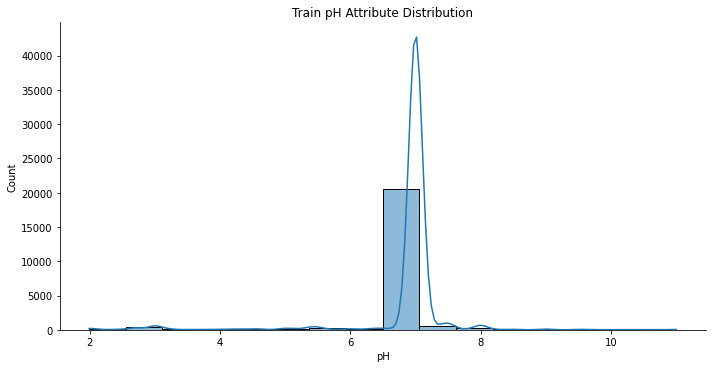

In [12]:
# Train PH Attribute Distribution
sns.displot(train_df['pH'], aspect=2, height=5, kde=True).set(title="Train pH Attribute Distribution")

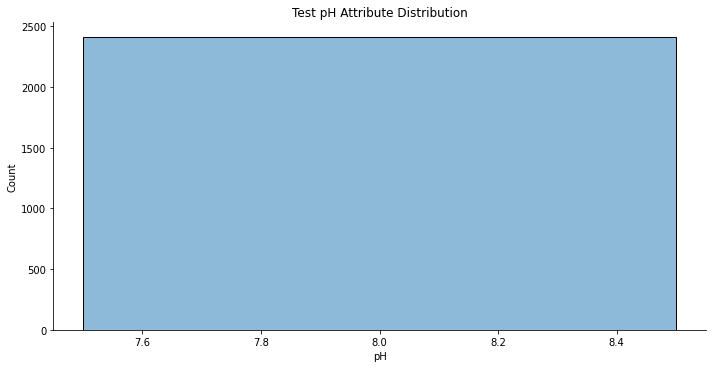

In [13]:
# Test Set pH value Distribution
sns.displot(test_df['pH'], aspect=2, height=5, kde=True).set(title="Test pH Attribute Distribution")

In [14]:
fig = px.histogram(train_df, x="pH",text_auto=True,log_y=True,nbins=10)
fig.show()

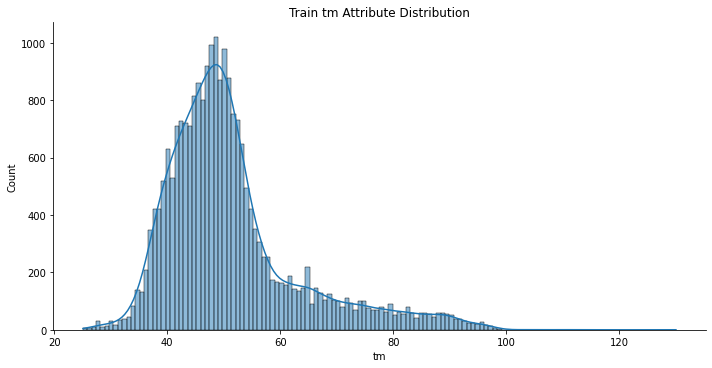

In [15]:
# Train PH Attribute Distribution
sns.displot(train_df['tm'], aspect=2, height=5, kde=True).set(title="Train tm Attribute Distribution")

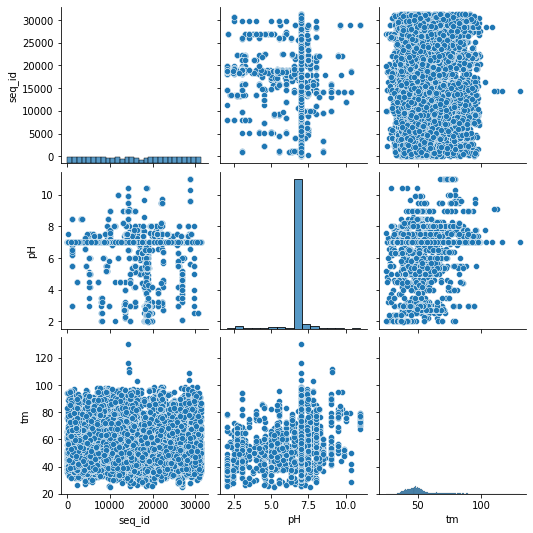

In [16]:
# Pair Plot on Train Set
sns.pairplot(train_df)

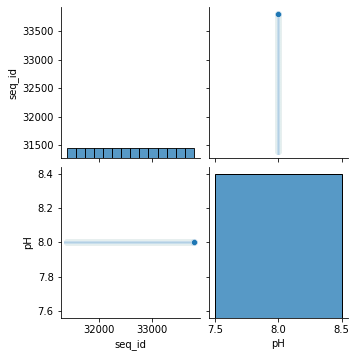

In [17]:
sns.pairplot(test_df)

<AxesSubplot:>

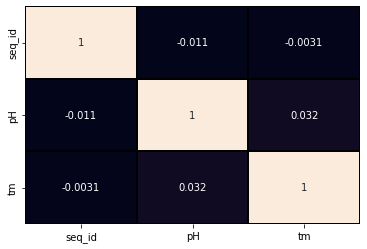

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(train_df.corr(),annot=True,linewidths=0.4,linecolor="black",cbar=False)

# Impute the Missing Values in PH Attribute with Mean

In [19]:
# Imputing Missing values in PH attribute
imputer = SimpleImputer(strategy="mean")
train_df["pH"] = imputer.fit_transform(train_df[["pH"]]).ravel()
val_df["pH"] = imputer.transform(val_df[["pH"]]).ravel()

# Extract Features from Pretrained ProtBert Model

In [20]:
#pip install transformers

In [21]:
# Load the ProtBert Model for Feature Extraction
#from transformers import BertModel, BertTokenizer
#tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
#model = BertModel.from_pretrained("Rostlab/prot_bert")
#model.eval()
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#print(device)
#model.to(device)

In [22]:
def extract_features(df):    
    embeddings_list = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        sequence_Example = ' '.join(row["protein_sequence"])
        sequence_Example = re.sub(r"[UZOB]", "X", sequence_Example)
        encoded_input = tokenizer(sequence_Example, add_special_tokens=True, padding=True, is_split_into_words=True, return_tensors="pt").to(device)
        with torch.no_grad():
            output = model(**encoded_input)
            output = output[1].detach().cpu().numpy()[0]
            embeddings_list.append(output)
            torch.cuda.empty_cache()

    return embeddings_list

In [23]:
#train_features = extract_features(train_df)
#valid_features = extract_features(val_df)
#test_features = extract_features(test_df)

In [24]:
import pickle
from pickle import dump
import joblib
train_features= joblib.load('/kaggle/input/enzym-data/data/train_features.pkl')
valid_features= joblib.load('/kaggle/input/enzym-data/data/valid_features.pkl')
test_features= joblib.load('/kaggle/input/enzym-data/data/test_features.pkl')

In [25]:
# Convert Extracted Features into Dense Columns
def convert_to_dense_columns(features_array):    
    df = pd.DataFrame(features_array)
    df.columns = ['Feature_' + str(x) for x in df.columns]
    return df

In [26]:
train_feats_df = convert_to_dense_columns(train_features)
val_feats_df = convert_to_dense_columns(valid_features)
test_feats_df = convert_to_dense_columns(test_features)

In [27]:
train_feats_df.head(10)

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_1014,Feature_1015,Feature_1016,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023
0,-0.244507,0.258235,-0.232656,-0.246818,-0.264462,-0.258669,-0.256564,-0.253849,0.238173,-0.249974,...,0.250758,-0.242066,0.255862,-0.253529,-0.251614,-0.236185,0.242557,0.246115,0.229978,-0.251330
1,-0.243061,0.256727,-0.231266,-0.245361,-0.262927,-0.257160,-0.255064,-0.252361,0.236757,-0.248504,...,0.249283,-0.240632,0.254365,-0.252042,-0.250136,-0.234778,0.241121,0.244662,0.228601,-0.249853
2,-0.264707,0.279267,-0.252097,-0.267160,-0.285857,-0.279726,-0.277497,-0.274621,0.257974,-0.270510,...,0.271344,-0.262115,0.276755,-0.274278,-0.272247,-0.255858,0.262635,0.266416,0.249249,-0.271950
3,-0.251635,0.265610,-0.239549,-0.253988,-0.271943,-0.266051,-0.263910,-0.261149,0.245179,-0.257203,...,0.258002,-0.249148,0.263198,-0.260820,-0.258870,-0.243152,0.249649,0.253273,0.236821,-0.258585
4,-0.249014,0.262933,-0.236989,-0.251357,-0.269244,-0.263373,-0.261239,-0.258487,0.242589,-0.254558,...,0.255353,-0.246538,0.260529,-0.258162,-0.256220,-0.240571,0.247036,0.250645,0.234272,-0.255933
5,-0.284510,0.299959,-0.271106,-0.287116,-0.306939,-0.300444,-0.298082,-0.295031,0.277357,-0.290672,...,0.291556,-0.281757,0.297296,-0.294669,-0.292514,-0.275107,0.282309,0.286326,0.268076,-0.292199
6,-0.269089,0.283872,-0.256284,-0.271580,-0.290562,-0.284338,-0.282075,-0.279155,0.262252,-0.274982,...,0.275828,-0.266457,0.281322,-0.278808,-0.276746,-0.260103,0.266985,0.270825,0.253390,-0.276443
7,-0.274235,0.289239,-0.261230,-0.276764,-0.296026,-0.289712,-0.287416,-0.284452,0.267292,-0.280217,...,0.281075,-0.271562,0.286651,-0.284100,-0.282007,-0.265109,0.272098,0.275997,0.258290,-0.281700
8,-0.270884,0.285707,-0.258035,-0.273382,-0.292413,-0.286174,-0.283906,-0.280979,0.264025,-0.276794,...,0.277643,-0.268243,0.283152,-0.280629,-0.278561,-0.261869,0.268773,0.272624,0.255133,-0.278260
9,-0.288983,0.304606,-0.275418,-0.291618,-0.311663,-0.305097,-0.302709,-0.299624,0.281745,-0.295215,...,0.296109,-0.286197,0.301914,-0.299257,-0.297078,-0.279468,0.286756,0.290820,0.272351,-0.296759


# Hand Engineering

In [28]:
# Create Protein Sequence Length as Feature
train_df["protein_length"] = train_df["protein_sequence"].apply(lambda x: len(x))
val_df["protein_length"] = val_df["protein_sequence"].apply(lambda x: len(x))
test_df["protein_length"] = test_df["protein_sequence"].apply(lambda x: len(x))

In [29]:
def return_amino_acid_df(df):    
    # Feature Engineering on Train Data
    search_amino=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    for amino_acid in search_amino:
         df[amino_acid]=df['protein_sequence'].str.count(amino_acid,re.I)
    return df

In [30]:
# Get the Amino Acid DataFrame for Train, Val and Test Set
train_df = return_amino_acid_df(train_df)
val_df = return_amino_acid_df(val_df)
test_df = return_amino_acid_df(test_df)

In [31]:
# Dropping Unnecessary Columns
train_df.drop(columns=["protein_sequence", "seq_id", "data_source"], inplace=True)
val_df.drop(columns=["protein_sequence", "seq_id", "data_source"], inplace=True)
test_df.drop(columns=["seq_id", "protein_sequence", "data_source"], inplace=True)

In [32]:
train_df.head(5)

,pH,tm,protein_length,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
5653,7.0,41.8,444,44,1,27,32,27,35,19,...,15,24,12,14,18,18,28,17,5,20
15912,7.0,43.6,323,33,4,19,16,9,33,10,...,18,6,13,8,10,25,26,21,0,1
20717,7.0,38.9,413,34,8,21,18,19,42,9,...,7,12,15,19,19,52,25,37,1,10
10385,7.0,35.4,354,25,8,19,29,19,18,6,...,8,16,6,14,22,22,22,20,3,10
17694,8.0,62.0,455,45,5,15,31,20,46,17,...,13,13,24,25,19,25,16,30,4,14


In [33]:
val_df.head(5)

,pH,tm,protein_length,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
16502,3.0,52.0,164,15,3,10,8,5,10,1,...,5,12,3,5,13,5,11,9,3,6
843,7.0,52.2,362,20,13,19,22,16,24,9,...,6,16,19,10,17,39,19,27,2,12
5731,7.0,57.6,732,41,5,39,46,21,48,24,...,9,31,84,34,64,75,36,33,16,17
8663,7.0,48.1,640,55,7,49,52,28,33,17,...,16,18,46,33,30,54,19,35,6,19
27605,7.0,53.1,909,54,9,45,66,45,38,23,...,34,40,35,39,33,80,57,50,21,33


In [34]:
test_df.head(10)

,pH,protein_length,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,8,221,22,4,15,8,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
1,8,221,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
2,8,220,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
3,8,221,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
4,8,221,22,4,15,7,11,19,0,6,...,0,19,17,13,3,18,8,13,6,6
5,8,221,22,4,15,7,10,20,0,6,...,0,19,17,13,3,18,8,13,6,6
6,8,221,22,4,15,7,10,19,1,6,...,0,19,17,13,3,18,8,13,6,6
7,8,221,22,4,15,7,10,19,0,7,...,0,19,17,13,3,18,8,13,6,6
8,8,221,23,4,15,7,10,19,0,6,...,0,19,17,13,3,18,7,13,6,6
9,8,221,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,7,13,6,6


In [35]:
# Reset the DataFrame indexes
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [36]:
test_df.head(10)

,pH,protein_length,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,8,221,22,4,15,8,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
1,8,221,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
2,8,220,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
3,8,221,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
4,8,221,22,4,15,7,11,19,0,6,...,0,19,17,13,3,18,8,13,6,6
5,8,221,22,4,15,7,10,20,0,6,...,0,19,17,13,3,18,8,13,6,6
6,8,221,22,4,15,7,10,19,1,6,...,0,19,17,13,3,18,8,13,6,6
7,8,221,22,4,15,7,10,19,0,7,...,0,19,17,13,3,18,8,13,6,6
8,8,221,23,4,15,7,10,19,0,6,...,0,19,17,13,3,18,7,13,6,6
9,8,221,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,7,13,6,6


# Combine ProBert Extracted Features with Hand Engineered Features

In [37]:
train_df_concat = pd.concat([train_df, train_feats_df], axis=1)
val_df_concat = pd.concat([val_df, val_feats_df], axis=1)
test_df_concat = pd.concat([test_df, test_feats_df], axis=1)

In [38]:
train_df_concat.head(10)

,pH,tm,protein_length,A,C,D,E,F,G,H,...,Feature_1014,Feature_1015,Feature_1016,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023
0,7.0,41.8,444,44,1,27,32,27,35,19,...,0.250758,-0.242066,0.255862,-0.253529,-0.251614,-0.236185,0.242557,0.246115,0.229978,-0.251330
1,7.0,43.6,323,33,4,19,16,9,33,10,...,0.249283,-0.240632,0.254365,-0.252042,-0.250136,-0.234778,0.241121,0.244662,0.228601,-0.249853
2,7.0,38.9,413,34,8,21,18,19,42,9,...,0.271344,-0.262115,0.276755,-0.274278,-0.272247,-0.255858,0.262635,0.266416,0.249249,-0.271950
3,7.0,35.4,354,25,8,19,29,19,18,6,...,0.258002,-0.249148,0.263198,-0.260820,-0.258870,-0.243152,0.249649,0.253273,0.236821,-0.258585
4,8.0,62.0,455,45,5,15,31,20,46,17,...,0.255353,-0.246538,0.260529,-0.258162,-0.256220,-0.240571,0.247036,0.250645,0.234272,-0.255933
5,7.0,47.0,1256,90,21,67,92,60,121,28,...,0.291556,-0.281757,0.297296,-0.294669,-0.292514,-0.275107,0.282309,0.286326,0.268076,-0.292199
6,7.0,48.7,140,12,14,9,6,5,7,3,...,0.275828,-0.266457,0.281322,-0.278808,-0.276746,-0.260103,0.266985,0.270825,0.253390,-0.276443
7,7.0,55.3,199,16,2,17,28,6,9,5,...,0.281075,-0.271562,0.286651,-0.284100,-0.282007,-0.265109,0.272098,0.275997,0.258290,-0.281700
8,7.0,91.8,269,32,0,8,30,14,16,7,...,0.277643,-0.268243,0.283152,-0.280629,-0.278561,-0.261869,0.268773,0.272624,0.255133,-0.278260
9,7.0,59.6,557,32,28,28,42,21,41,13,...,0.296109,-0.286197,0.301914,-0.299257,-0.297078,-0.279468,0.286756,0.290820,0.272351,-0.296759


In [39]:
# Seperate Dependent and Independent Variables
X_train = train_df_concat.drop(columns=["tm"])
y_train = train_df_concat["tm"]

X_val = val_df_concat.drop(columns=["tm"])
y_val = val_df_concat["tm"]

X_test = test_df_concat

# Modelling

In [40]:
# random_grid={'max_depth':list(np.arange(10, 100, step=10)),
#               'n_estimators':np.arange(10, 500, step=50),
#               'max_features':randint(1,7),
#               'min_samples_leaf':randint(1,4),
#               'min_samples_split':np.arange(2, 10, step=2)
#          }

# rf = RandomForestRegressor(random_state = 42)
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                               n_iter = 50, scoring='neg_mean_absolute_error', 
#                               cv =3, verbose=2, random_state=42, n_jobs=-1,
#                               return_train_score=True)

# # Fit the random search model
# rf_random.fit(X_train,y_train)

# model = XGBRegressor()
# params = {"n_estimators":[100,200,300],"max_depth":[3,5,7],"learning_rate":[0.1,0.05,0.001]}
# tuned_model = GridSearchCV(model,param_grid=params,cv=5,verbose=2,n_jobs=-1).fit(X_train,y_train)

# print(tuned_model.best_params_)

# Model Performance

In [41]:
#model = XGBRegressor()
#params = {"n_estimators":[150,200,300],"max_depth":[3,7,8],"learning_rate":[0.1,0.05,0.001]}
#tuned_model = GridSearchCV(model,param_grid=params,cv=5,verbose=2,n_jobs=-1).fit(X_train,y_train)

In [42]:
# The best params are
#tuned_model.best_params_

In [43]:
# Fit the Model with Best Hyperparameters
model = XGBRegressor(learning_rate=0.1, max_depth=8, n_estimators=150, tree_method="gpu_hist")
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [44]:
# Checking the performance of the model on Train, Val and Test Set
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
print("Mean Absolute error on Train data is:{}".format(mean_absolute_error(y_train, y_pred_train)))
print("Mean Absolute error on Val data is:{}".format(mean_absolute_error(y_val, y_pred_val)))

Mean Absolute error on Train data is:3.786300779063591
Mean Absolute error on Val data is:5.577358069558874


In [45]:
# Correlation Value
print("Training Correlation Value: {}".format(spearmanr(y_pred_train, y_train)))
print("Validation Correlation Value: {}".format(spearmanr(y_pred_val, y_val)))

Training Correlation Value: SpearmanrResult(correlation=0.8216982293231895, pvalue=0.0)
Validation Correlation Value: SpearmanrResult(correlation=0.5788567219567935, pvalue=0.0)


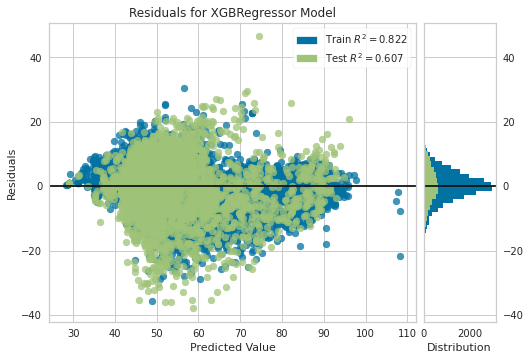

In [46]:
from yellowbrick.regressor import ResidualsPlot,prediction_error
visualizer= ResidualsPlot(model)
visualizer.fit(np.array(X_train), np.array(y_train).reshape( 23184,))
visualizer.score(np.array(X_val), np.array(y_val).reshape(5797,))
visualizer.show();

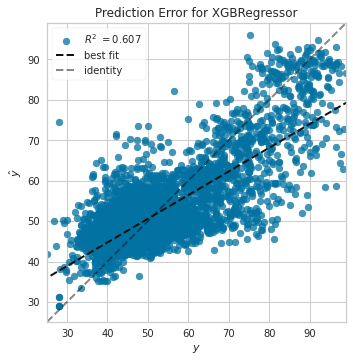

In [47]:
visualizer_s= prediction_error(model, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val));

# Feature Importance

In [48]:
import shap
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

2022-12-19 01:23:58.566838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 01:23:58.568286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 01:23:58.569108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 01:23:58.571069: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [49]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['Feature', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,Feature,shap_importance
0,pH,10.20944
12,M,2.300732
1,protein_length,1.148366
2,A,0.92547
10,K,0.916082
...,...,...
386,Feature_364,0.0
387,Feature_365,0.0
388,Feature_366,0.0
389,Feature_367,0.0


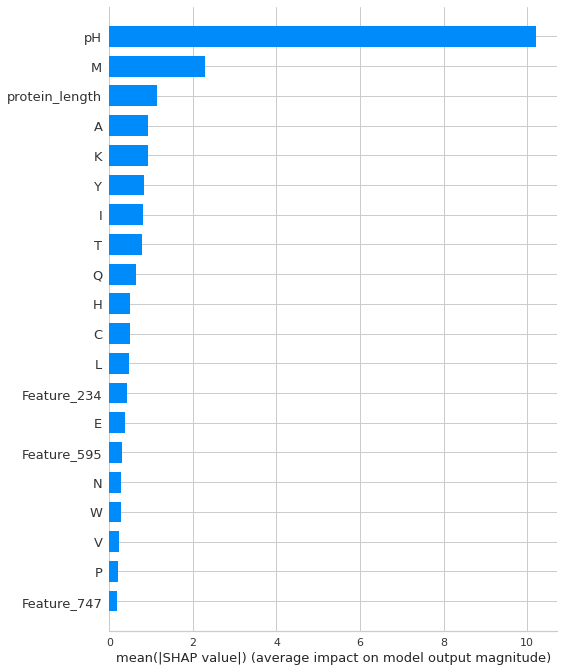

In [50]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

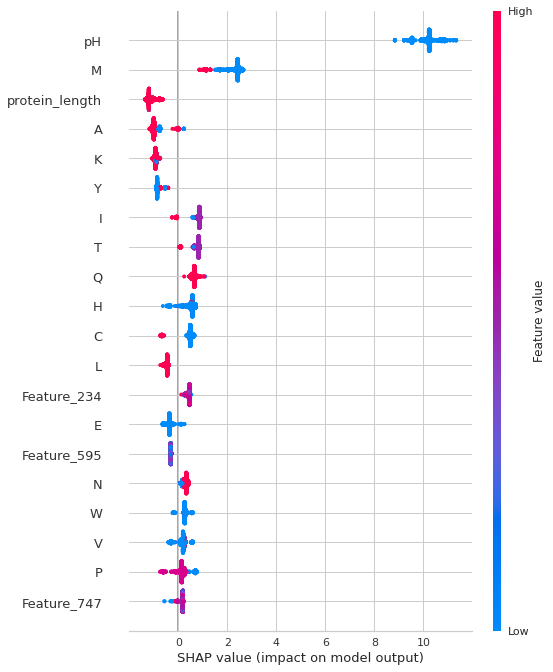

In [51]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)


# Submission

In [52]:
# Let's Do the Submission
y_pred_test = model.predict(X_test)
sub_df["tm"] = y_pred_test
sub_df.to_csv("submission.csv", index=False)

In [53]:
submission=pd.read_csv("submission.csv")
submission

,seq_id,tm
0,31390,63.644640
1,31391,63.644640
2,31392,63.194424
3,31393,60.611930
4,31394,63.672363
...,...,...
2408,33798,61.828970
2409,33799,64.326660
2410,33800,64.356470
2411,33801,64.242860
